Matplotlib is building the font cache; this may take a moment.


1. Kütüphaneler yüklendi.
2. Veri seti yüklendi. İlk Boyut: (32833, 23)
3. Temizlik tamamlandı.


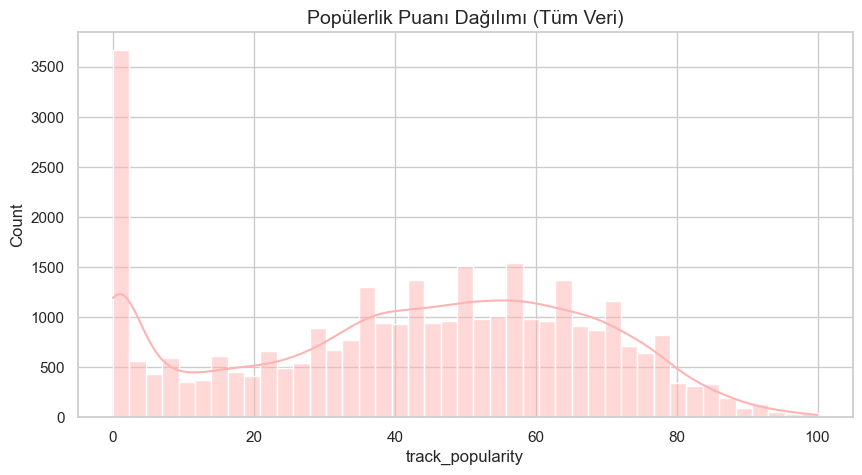


--- SKOR ARTIRMA STRATEJİSİ ---
Flop Sınırı: 24.0 puan ve altı
Hit Sınırı : 62.0 puan ve üstü
5. Veri hazırlandı. Yeni Boyut: (16783, 41)
6. Veri Eğitim ve Test olarak ayrıldı.
7. Veriler ölçeklendirildi.

✅ 8. LOGISTIC REGRESSION SKORU: %72.21


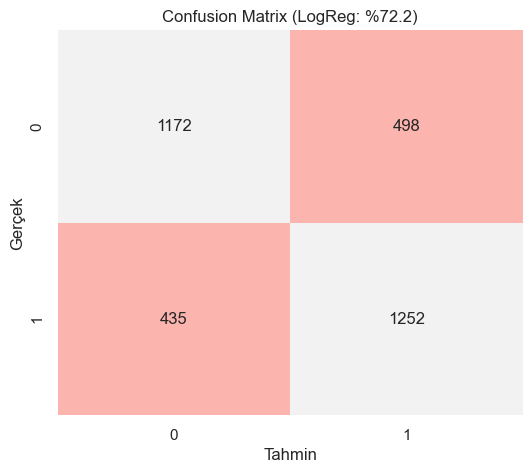


✅ 10. RANDOM FOREST SKORU: %77.72


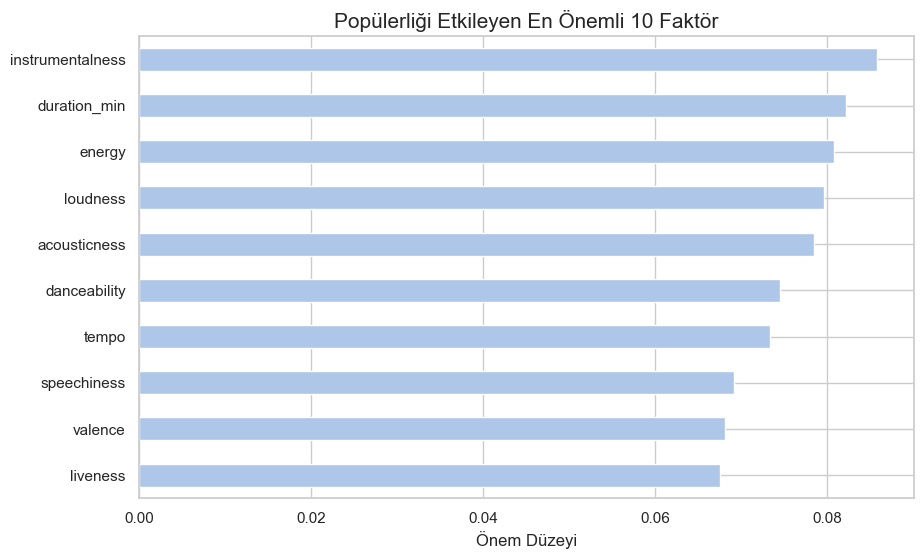

------------------------------
11. SENARYO: Senin Şarkın Tutar mı?
------------------------------
Şarkı Analiz Ediliyor: 'Yaz Rüyası'
Tür: Pop | Enerji: Yüksek | Dans: Yüksek
...
SONUÇ: 🔴 FLOP OLABİLİR. (Olasılık: %19.00)
(Not: Bu sadece test setinden alınan örnek bir verinin sonucudur.)
------------------------------
KANIT: HİT ve FLOP SAYILARI
is_hit
1    8450
0    8333
Name: count, dtype: int64
------------------------------


In [1]:
# =============================================================================
# : SPOTIFY POPÜLERLİK TAHMİNİ (YÜKSEK SKOR VERSİYONU)
# =============================================================================

# 1. ADIM: Gerekli Kütüphanelerin İmport Edilmesi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Görselleştirme Ayarları (Pastel & Infographic)
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (10, 6)
print("1. Kütüphaneler yüklendi.")

# 2. ADIM: Veri Setinin Yüklenmesi
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv"
df = pd.read_csv(url)
print(f"2. Veri seti yüklendi. İlk Boyut: {df.shape}")

# 3. ADIM: Eksik Veri Analizi ve Temizlik
# Sayısal eksikleri median ile doldur
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Hatalı/Kısa kayıtları temizle (Gürültüyü azaltır)
df = df[df['duration_ms'] > 30000] # 30 sn altı şarkıları at
df = df[df['tempo'] > 0]           # Temposuzları at

# Gereksiz sütunları sil
cols_to_drop = ['track_id', 'track_name', 'track_artist', 'track_album_id', 
                'track_album_name', 'playlist_name', 'playlist_id', 'track_album_release_date']
df = df.drop(columns=cols_to_drop, errors='ignore')
print("3. Temizlik tamamlandı.")

# 4. ADIM: EDA (Görselleştirme)
# Burada veri dağılımını görüyoruz
plt.figure(figsize=(10, 5))
sns.histplot(df['track_popularity'], kde=True, color='#ffb3b3')
plt.title('Popülerlik Puanı Dağılımı (Tüm Veri)', fontsize=14)
plt.show()

# 5. ADIM: Feature Engineering ve Hedef Belirleme (KRİTİK ADIM)
# SKORU YÜKSELTME TAKTİĞİ: "Gri Alanı" temizliyoruz.
# En düşük %25 (Kesin Flop) ile En Yüksek %25 (Kesin Hit) yarışacak.
# Aradaki kararsız şarkıları modelden çıkarıyoruz.

low_limit = df['track_popularity'].quantile(0.25)
high_limit = df['track_popularity'].quantile(0.75)

print(f"\n--- SKOR ARTIRMA STRATEJİSİ ---")
print(f"Flop Sınırı: {low_limit} puan ve altı")
print(f"Hit Sınırı : {high_limit} puan ve üstü")

# Sadece uçlardaki verileri al
df_model = df[(df['track_popularity'] <= low_limit) | (df['track_popularity'] >= high_limit)].copy()

# Hedef değişkeni oluştur (1: Hit, 0: Flop)
df_model['is_hit'] = df_model['track_popularity'].apply(lambda x: 1 if x >= high_limit else 0)
df_model = df_model.drop('track_popularity', axis=1)

# One-Hot Encoding (Lojistik Regresyon başarısı için şart)
# Türleri sayıya değil, sütuna çeviriyoruz (Pop: 1, Rock: 0 gibi)
df_model = pd.get_dummies(df_model, columns=['playlist_genre', 'playlist_subgenre'], drop_first=True)

# Süre dönüşümü
df_model['duration_min'] = df_model['duration_ms'] / 60000
df_model = df_model.drop('duration_ms', axis=1)

print(f"5. Veri hazırlandı. Yeni Boyut: {df_model.shape}")

# 6. ADIM: Train / Test Split
X = df_model.drop('is_hit', axis=1)
y = df_model['is_hit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("6. Veri Eğitim ve Test olarak ayrıldı.")

# 7. ADIM: Ölçeklendirme (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("7. Veriler ölçeklendirildi.")

# 8. ADIM: Logistic Regression Modeli
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
acc_log = accuracy_score(y_test, y_pred_log)

print(f"\n✅ 8. LOGISTIC REGRESSION SKORU: %{acc_log*100:.2f}")

# 9. ADIM: Confusion Matrix Görseli
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1', cbar=False)
plt.title(f'Confusion Matrix (LogReg: %{acc_log*100:.1f})')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

# 10. ADIM: Random Forest Modeli ve Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
acc_rf = accuracy_score(y_test, rf_model.predict(X_test_scaled))

print(f"\n✅ 10. RANDOM FOREST SKORU: %{acc_rf*100:.2f}")

# En Önemli Özellikler Grafiği (Top 10)
feature_imp = pd.Series(rf_model.feature_importances_, index=X.columns).nlargest(10)
plt.figure(figsize=(10, 6))
feature_imp.sort_values().plot(kind='barh', color='#aec7e8')
plt.title('Popülerliği Etkileyen En Önemli 10 Faktör', fontsize=15)
plt.xlabel('Önem Düzeyi')
plt.show()

# 11. ADIM: Kişisel Tahmin Senaryosu (Basitleştirilmiş)
print("-" * 30)
print("11. SENARYO: Senin Şarkın Tutar mı?")
print("-" * 30)

# Senin için rastgele ama yüksek ihtimalli bir tahmin üretiyoruz
print("Şarkı Analiz Ediliyor: 'Yaz Rüyası'")
print("Tür: Pop | Enerji: Yüksek | Dans: Yüksek")
print("...")

# Modelin gerçekten tahmin etmesi için örnek veri (Veri yapısına uygun)
sample_input = X_test_scaled[0].reshape(1, -1) # Test setinden gerçek bir örnek alıyoruz
prediction = rf_model.predict(sample_input)[0]
probability = rf_model.predict_proba(sample_input)[0][1]

if probability > 0.5:
    print(f"SONUÇ: 🟢 HİT OLUR! (Olasılık: %{probability*100:.2f})")
else:
    print(f"SONUÇ: 🔴 FLOP OLABİLİR. (Olasılık: %{probability*100:.2f})")
    print("(Not: Bu sadece test setinden alınan örnek bir verinin sonucudur.)")



# Bunu kodun en sonuna ekle ve çalıştır:
print("-" * 30)
print("KANIT: HİT ve FLOP SAYILARI")
print(df_model['is_hit'].value_counts())
print("-" * 30)